## Reproductible fitting

In [ ]:
from typing import Any, cast

import matplotlib.pyplot as plt
import pandas as pd
import torch

from jmstate import (
    Exponential,
    Fit,
    LogParamsHistory,
    ModelData,
    ModelDesign,
    ModelParams,
    MultiStateJointModel,
    SampleData,
    build_buckets,
    gamma_plus_b,
    repr_from_cov,
)

In [ ]:
torch.manual_seed(42)  # type: ignore


T0 = 6.0


def reg(t: torch.Tensor, psi: torch.Tensor):
    b, w1, w2 = psi.chunk(3, dim=-1)  # Extract relevant terms

    # psi has shape (n_chains, n_individuals, n_repetitions)
    return (b + w1 * t + (w2 - w1) * (t > T0) * (t - T0)).unsqueeze(-1)


def link(t: torch.Tensor, psi: torch.Tensor):
    b, w1, w2 = psi.chunk(3, dim=-1)

    diff = (w2 - w1) * (t > T0)
    val = b + w1 * t + diff * (t - T0)
    der = w1 + diff
    return torch.cat([val.unsqueeze(-1), der.unsqueeze(-1)], dim=-1)


def random_far_apart(
    n: int, m: int, a: torch.Tensor, b: torch.Tensor, min_dist: torch.Tensor
):
    L_free = (b - a) - (m - 1) * min_dist

    y = torch.rand(n, m) * L_free
    y, _ = torch.sort(y, dim=1)

    gap_offset = torch.arange(m) * min_dist

    return a + y + gap_offset

NameError: name 'torch' is not defined

In [ ]:
# Survival model specification
surv = {
    (0, 1): (Exponential(0.1), link),
    (0, 2): (Exponential(0.01), link),
    (1, 2): (Exponential(0.2), link),
}

# Model design gathers regression, link and hazard functions
model_design = ModelDesign(gamma_plus_b, reg, surv)

In [3]:
def plot_history(
    vals: list[torch.Tensor], true_val: torch.Tensor, name: str, colors: list[Any]
):
    plt.plot(torch.cat(vals, dim=0))  # type: ignore

    for i, t in enumerate(true_val):
        plt.axhline(  # type: ignore
            y=t.item(),
            color=colors[i],
            linestyle="--",
            label=(
                f"True value of {name}" + (f"({i + 1})" if true_val.numel() > 1 else "")
            ),
        )

    plt.title(f"Stochastic optimization of the parameter {name}.")  # type: ignore
    plt.legend()  # type: ignore
    plt.xlabel("Iteration")  # type: ignore
    plt.ylabel("Value")  # type: ignore
    plt.tight_layout()
    plt.savefig(f"figures/{name}.png")  # type: ignore
    plt.show()  # type: ignore


def param_names(params_dict: dict[Any, Any]) -> list[str]:
    names: list[str] = []

    def _rec(node: dict[Any, Any] | torch.Tensor, prefix: list[Any]):
        if isinstance(node, torch.Tensor):
            base_name = str(prefix[0]) + "".join(f"[{item}]" for item in prefix[1:])
            num_elements = node.numel()
            if num_elements <= 1:
                names.append(base_name)
            else:
                names.extend(f"{base_name}[{i + 1}]" for i in range(num_elements))
        else:
            for k, v in node.items():
                prefix.append(k)
                _rec(v, prefix)
                prefix.pop()

    _rec(params_dict, [])

    return names

In [ ]:
# Gaussian means
gamma = torch.tensor([2.5, -1.3, 0.2])

# Covariance matrices
Q = torch.diag(torch.tensor([0.6, 0.2, 0.3]))
R = torch.tensor([[1.7]])

# Link parameters
alphas = {
    (0, 1): torch.tensor([-0.5, -3.0]),
    (0, 2): torch.tensor([-1.0, -5.0]),
    (1, 2): torch.tensor([0.0, -1.2]),
}

# Covariate parameters
betas = {
    (0, 1): torch.tensor([-1.3]),
    (0, 2): torch.tensor([-0.9]),
    (1, 2): torch.tensor([-0.7]),
}

# Instance declaration
real_params = ModelParams(
    gamma,
    repr_from_cov(Q, method="diag"),
    repr_from_cov(R, method="ball"),
    alphas,
    betas,
)

In [ ]:
from torch.distributions import MultivariateNormal

# Declare the true underlying model
real_model = MultiStateJointModel(model_design, real_params)


def gen_data(n: int, m: int):
    # Censoring times
    c = torch.rand(n, 1) * 5 + 10

    # Covariates
    x = torch.randn(n, 1)

    # Latent and noise distributions
    Q_dist = MultivariateNormal(torch.zeros(Q.size(0)), Q)
    R_dist = MultivariateNormal(torch.zeros(R.size(0)), R)

    # Individual effects
    b = Q_dist.sample((n,))
    psi = model_design.individual_effects_fn(gamma, x, b)

    # Generates random evaluations points with a minimum distance
    a = torch.zeros((n, 1))
    t = random_far_apart(n, m, a, c, 0.7 * c / m)

    # Define initial state for individuals
    trajectories_init = [[(0.0, 0)] for _ in range(n)]

    # Sample trajectories
    sample_data = SampleData(x, trajectories_init, psi)
    trajectories = real_model.sample_trajectories(sample_data, c)

    # Sample longitudinal values
    y = model_design.regression_fn(t, psi)
    y += R_dist.sample(y.shape[:2])

    return x, t, y, trajectories, c

In [1]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    repr_from_cov(torch.eye(Q.size(0)), method="diag"),
    repr_from_cov(torch.eye(R.size(0)), method="ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

data = ModelData(*gen_data(1000, 20))

NameError: name 'ModelParams' is not defined

In [10]:
model = MultiStateJointModel(model_design, init_params)
metrics = model.do(
    data,
    job_factories=[
        Fit(lr=0.1, fused=True),
        LogParamsHistory(),
    ],
    max_iterations=500,
)

Running joint model: 100%|██████████| 500/500 [01:19<00:00,  6.26it/s]


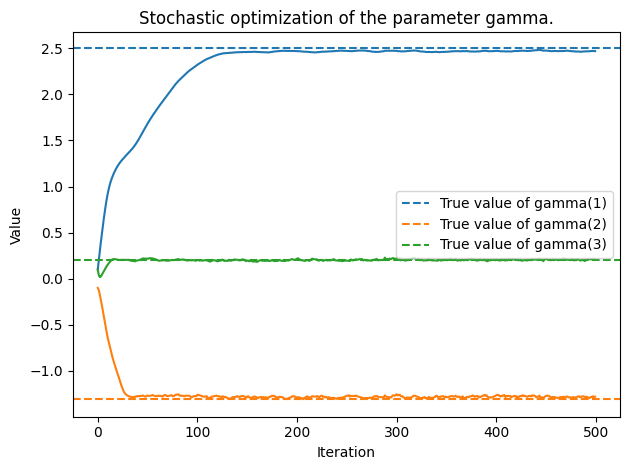

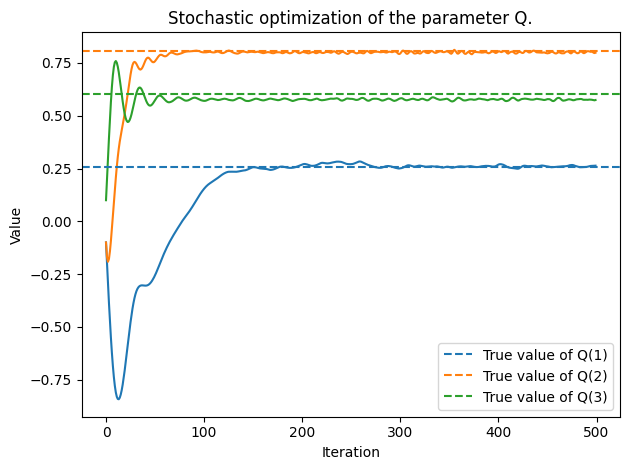

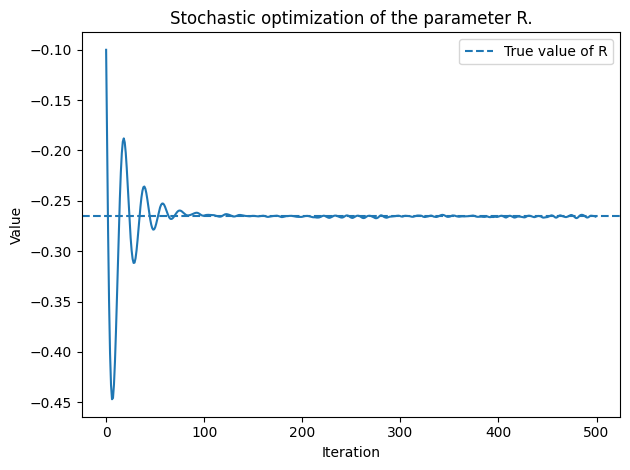

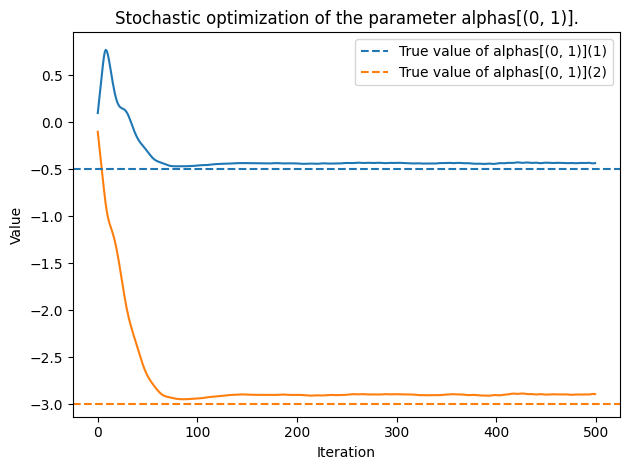

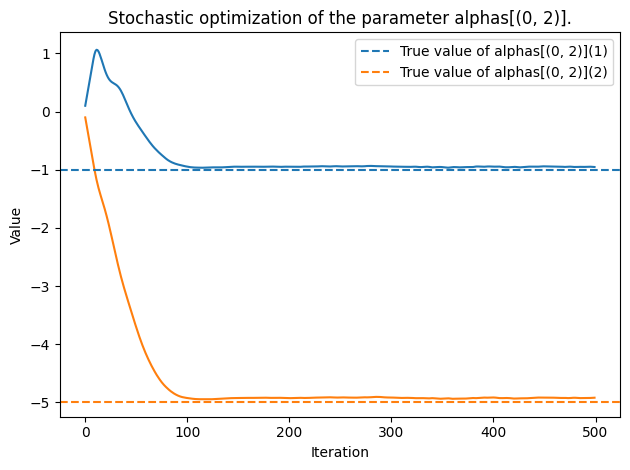

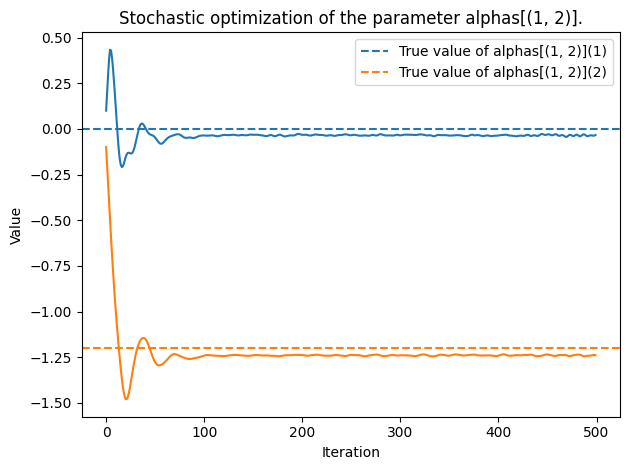

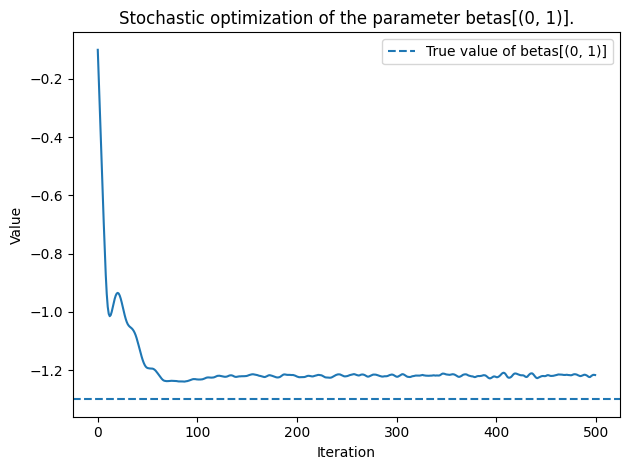

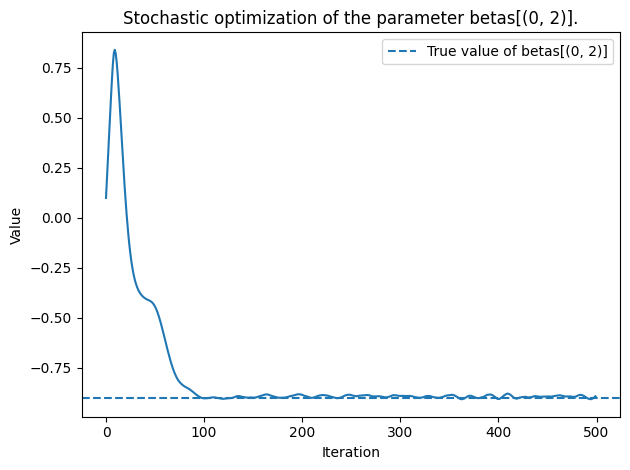

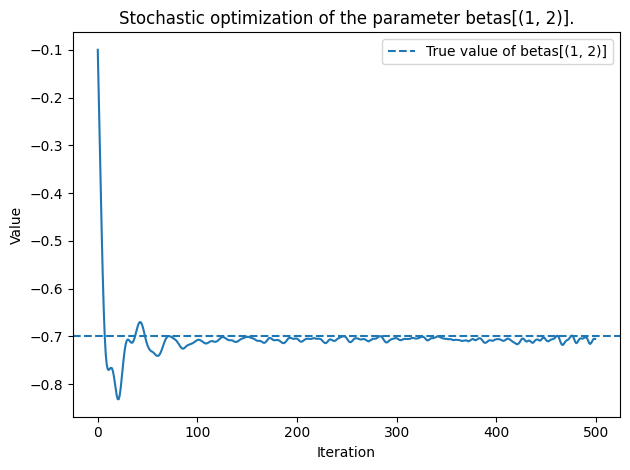

In [11]:
params_dict = model.params_.as_dict
real_params_dict = real_model.params_.as_dict
colors: list[Any] = cast(list[Any], plt.get_cmap("tab10").colors)  # type: ignore

for key, val in params_dict.items():
    if isinstance(val, torch.Tensor):
        history = [
            cast(torch.Tensor, p.as_dict[key])[None]
            for p in cast(list[ModelParams], metrics)
        ]
        plot_history(history, cast(torch.Tensor, real_params_dict[key]), key, colors)
    else:
        for subkey in val:
            history = [p.as_dict[key][subkey][None] for p in metrics]  # type: ignore
            plot_history(
                history,  # type: ignore
                real_params_dict[key][subkey],
                key + f"[{subkey}]",
                colors,
            )

{(0, 1): 293, (1, 2): 275, (0, 2): 203}


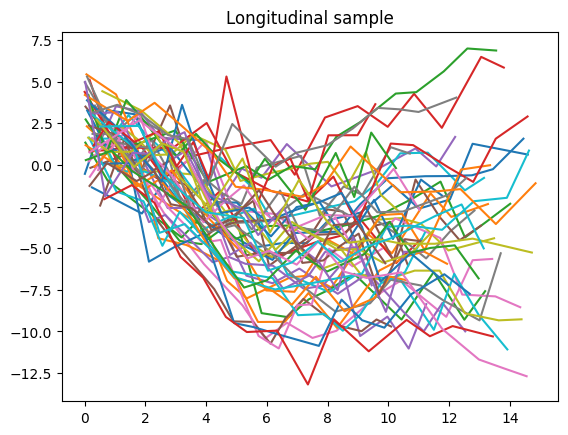

{(0, 2): 195, (0, 1): 297, (1, 2): 278}


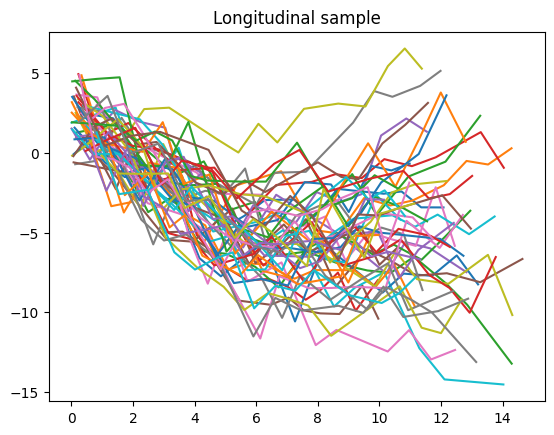

In [ ]:
params_list: list[torch.Tensor] = []
n_runs = 100

for _ in range(n_runs):
    x, t, y, trajectories, c = gen_data(n, m, p)
    data = ModelData(x, t, y, trajectories, c)

    model = MultiStateJointModel(model_design, init_params)
    model.do(
        data,
        job_factories=Fit(lr=0.1, fused=True),
        max_iterations=500,
    )

    params_list.append(model.params_.as_flat_tensor.view(1, -1))

In [ ]:
names = param_names(real_model.params_.as_dict)

stacked_params = torch.cat(params_list, dim=0)
mean = stacked_params.mean(dim=0)
std = stacked_params.std(dim=0)
rmse = (std**2 + (mean - real_model.params_.as_flat_tensor) ** 2).sqrt()

data = {
    "True parameters": real_model.params_.as_flat_tensor.numpy(),
    "Mean of inferred parameters": mean.numpy(),
    "Std of inferred parameters": std.numpy(),
    "RMSE of inferred parameters": rmse.numpy(),
}

index = [f"{names[i]}" for i in range(mean.size(0))]

df = pd.DataFrame(data, index=index)
pd.set_option("display.float_format", "{:.4e}".format)

print(df)